In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("processed_kelulusan.csv")
X = df.drop("Lulus", axis=1)
y = df["Lulus"]

# split: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30,  random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50,random_state=42
)
print(X_train.shape, X_val.shape, X_test.shape)

(7, 5) (1, 5) (2, 5)


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

num_cols = X_train.select_dtypes(include="number").columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
], remainder="drop")

rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt",
    class_weight="balanced", random_state=42
)

pipe = Pipeline([("pre", pre), ("clf", rf)])
pipe.fit(X_train, y_train)

y_val_pred = pipe.predict(X_val)
print("Baseline RF — F1(val):", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred, digits=3))

Baseline RF — F1(val): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1

    accuracy                          1.000         1
   macro avg      1.000     1.000     1.000         1
weighted avg      1.000     1.000     1.000         1



In [21]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="f1_macro", n_jobs=-1)
print("CV F1-macro (train):", scores.mean(), "±", scores.std())

CV F1-macro (train): 0.7 ± 0.03333333333333338


In [22]:
from sklearn.model_selection import GridSearchCV

param = {
  "clf__max_depth": [None, 12, 20, 30],
  "clf__min_samples_split": [2, 5, 10]
}

gs = GridSearchCV(pipe, param_grid=param, cv=skf,
                  scoring="f1_macro", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best_model = gs.best_estimator_
y_val_best = best_model.predict(X_val)
print("Best RF — F1(val):", f1_score(y_val, y_val_best, average="macro"))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2}
Best RF — F1(val): 1.0


F1(test): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2

Confusion Matrix (test):
[[1 0]
 [0 1]]
ROC-AUC(test): 1.0


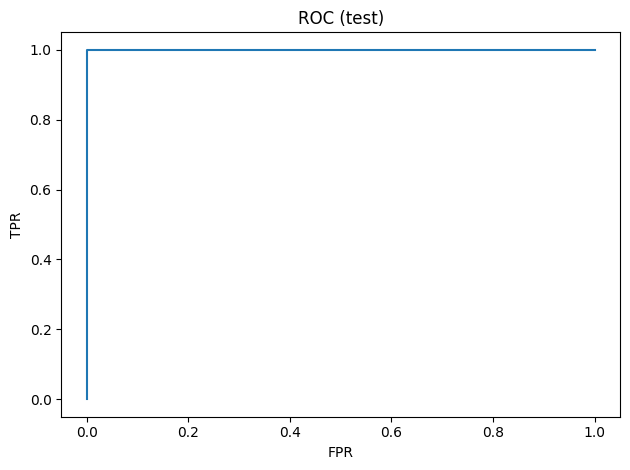

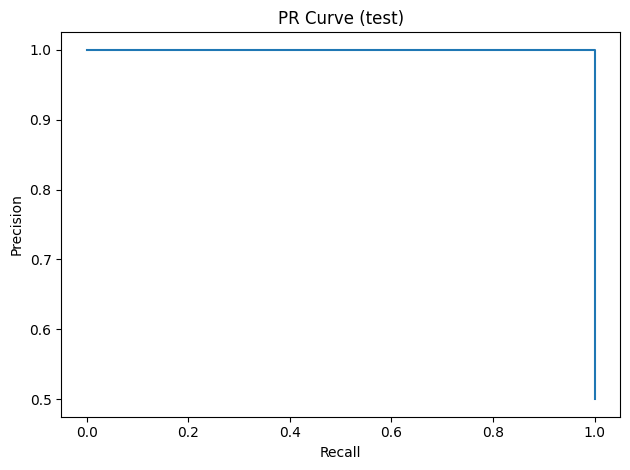

In [23]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

final_model = best_model  # pilih terbaik; jika baseline lebih baik, gunakan pipe

y_test_pred = final_model.predict(X_test)
print("F1(test):", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion Matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

# ROC-AUC (bila ada predict_proba)
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:,1]
    try:
        print("ROC-AUC(test):", roc_auc_score(y_test, y_test_proba))
    except:
        pass
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
    plt.tight_layout(); plt.savefig("roc_test.png", dpi=120)

    prec, rec, _ = precision_recall_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve (test)")
    plt.tight_layout(); plt.savefig("pr_test.png", dpi=120)

In [24]:
# 6a) Feature importance native (gini)
try:
    import numpy as np
    importances = final_model.named_steps["clf"].feature_importances_
    fn = final_model.named_steps["pre"].get_feature_names_out()
    top = sorted(zip(fn, importances), key=lambda x: x[1], reverse=True)
    print("Top feature importance:")
    for name, val in top[:10]:
        print(f"{name}: {val:.4f}")
except Exception as e:
    print("Feature importance tidak tersedia:", e)

# 6b) (Opsional) Permutation Importance
# from sklearn.inspection import permutation_importance
# r = permutation_importance(final_model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
# ... (urutkan dan laporkan)

Top feature importance:
num__IPK: 0.2483
num__IPK_x_Study: 0.2279
num__Waktu_Belajar_Jam: 0.2211
num__Rasio_Absensi: 0.1565
num__Jumlah_Absensi: 0.1463


In [25]:
import joblib
joblib.dump(final_model, "rf_model.pkl")
print("Model disimpan sebagai rf_model.pkl")

Model disimpan sebagai rf_model.pkl


In [ ]:
# Contoh sekali jalan (input fiktif), sesuaikan nama kolom:
import pandas as pd, joblib
mdl = joblib.load("rf_model.pkl")
sample = pd.DataFrame([{
  "IPK": 3.4,
  "Jumlah_Absensi": 4,
  "Waktu_Belajar_Jam": 7,
  "Rasio_Absensi": 4/14,
  "IPK_x_Study": 3.4*7
}])
print("Prediksi:", int(mdl.predict(sample)[0]))

Prediksi: 1
